<a href="https://colab.research.google.com/github/etienne-tov/Tomato-Leaf-Classification/blob/master/AgriVision_Tomato_Leaf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tomato Leaf Image Classification

### ***Context:***
Agriculture plays a crucial role in global food security. The health of crops, including tomatoes, is essential to ensure optimal yields. Diseases, pests, and plant health issues can lead to significant losses for farmers. Early detection of these issues is, therefore, paramount.

### ***Objective*** :
The objective of this project is to develop a leaf image classification model capable of accurately identifying the health status of tomato plants, diseases, pests, and potential issues. This model will assist farmers in quickly diagnosing problems, taking appropriate management measures, and optimizing their production, thereby improving crop health, reducing crop losses, and promoting sustainable agriculture.



In the context of enhancing agricultural practices and crop health, this project utilizes a dataset from [Kaggle ](https://www.kaggle.com/arjuntejaswi/plant-village) to develop a leaf image classification model aimed at early detection of tomato plant diseases, pests, and health issues, thereby contributing to improved crop management and reduced losses for farmers.



The dataset includes ten distinct classes, each corresponding to specific conditions and diseases affecting tomato leaves. These classes range from bacterial:

1. **Bacterial_spot**: This class corresponds to tomato leaves exhibiting symptoms of bacterial spot, a bacterial disease that can affect plant health.

2. **Early_blight**: This class represents tomato leaves affected by early blight, a fungal disease that can cause brown spots on the leaves.

3. **Healthy**: This class represents tomato leaves with no apparent signs of disease or major issues.

4. **Late_blight**: This class pertains to tomato leaves affected by late blight, a fungal disease that can damage plants.

5. **Leaf_Mold**: This class represents leaf mold in tomato leaves, a fungal disease that results in spots on the leaves.

6. **Septoria_leaf_spot**: This class corresponds to Septoria leaf spot disease in tomato leaves, which causes characteristic spots.

7. **Spider_mites_Two_spotted_spider_mite**: This class represents tomato leaves affected by the two-spotted spider mite, a harmful pest.

8. **Target_Spot**: This class is associated with target spot disease in tomatoes, which causes circular spots on the leaves.

9. **mosaic_virus**: This class represents tomato leaves infected by the tomato mosaic virus, leading to mosaic-like symptoms.

10. **YellowLeaf__Curl_Virus**: This class represents tomato leaves affected by the tomato yellow leaf curl virus, leading to yellowing and curling of the leaves.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!git clone https://github.com/etienne-tov/Tomato-Leaf-Classification.git

fatal: destination path 'Tomato-Leaf-Classification' already exists and is not an empty directory.


In [3]:
folder_path = '/content/Tomato-Leaf-Classification/dataset'

In [4]:
IMAGE_SIZE = 124
BATCH_SIZE = 32
EPOCHS = 25

In [5]:
dataset = tf.keras.utils.image_dataset_from_directory(
    folder_path,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True
)

Found 16011 files belonging to 10 classes.


In [6]:
class_names = dataset.class_names
class_names[-3] = class_names[-3].replace('Tomato__', '')
class_names[-2] = class_names[-2].replace('Tomato__', '')
for idx, name in enumerate(class_names):
  class_names[idx] = class_names[idx].replace("Tomato_", '')

class_names[-4] = class_names[-4].replace('_', '')
class_names

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites_Two_spotted_spider_mite',
 'TargetSpot',
 'YellowLeaf__Curl_Virus',
 'mosaic_virus',
 'healthy']

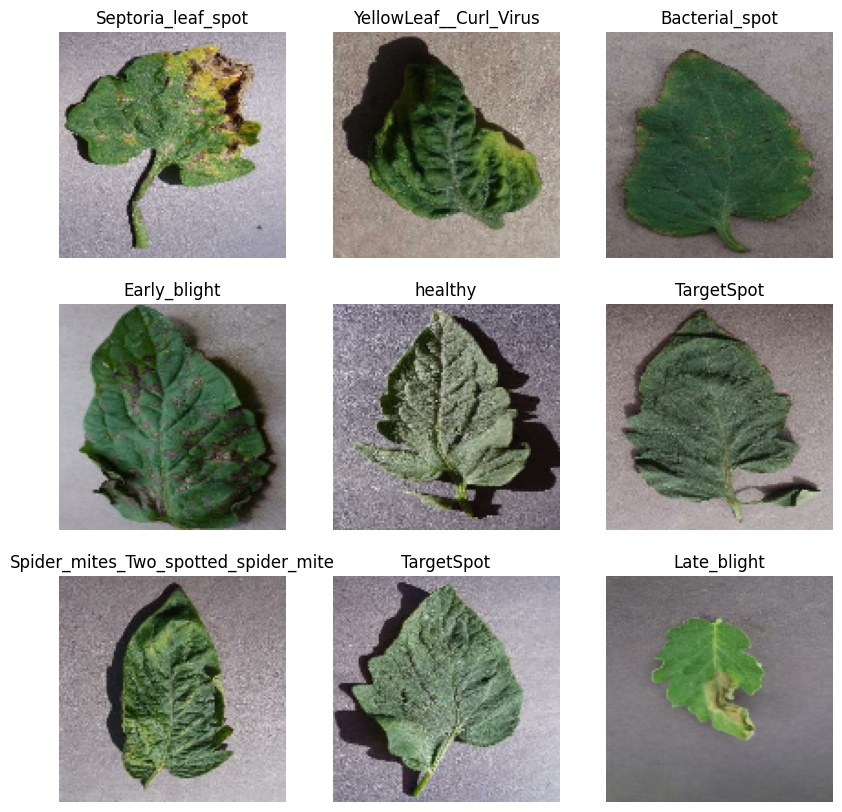

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title( class_names[int(labels[i])])
        plt.axis("off")

In [8]:
len(dataset)

501

In [9]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [10]:
train_ds, valid_ds, test_ds = get_dataset_partitions_tf(dataset, len(dataset))

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(1)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(1)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [14]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)

model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),

    tf.keras.layers.Dense(len(class_names), activation="softmax")
])

model.build(input_shape=input_shape)

In [15]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [16]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
)

In [17]:
history = model.fit(train_ds,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=valid_ds, callbacks=[callback]
          )

Epoch 1/25
400/400 [==============================] - 43s 43ms/step - loss: 1.6809 - accuracy: 0.4041 - val_loss: 1.3252 - val_accuracy: 0.5487
Epoch 2/25
400/400 [==============================] - 7s 18ms/step - loss: 1.0668 - accuracy: 0.6304 - val_loss: 0.9566 - val_accuracy: 0.6612
Epoch 3/25
400/400 [==============================] - 7s 17ms/step - loss: 0.7842 - accuracy: 0.7264 - val_loss: 0.9887 - val_accuracy: 0.6500
Epoch 4/25
400/400 [==============================] - 7s 18ms/step - loss: 0.6540 - accuracy: 0.7755 - val_loss: 0.6888 - val_accuracy: 0.7550
Epoch 5/25
400/400 [==============================] - 7s 18ms/step - loss: 0.5491 - accuracy: 0.8102 - val_loss: 0.4909 - val_accuracy: 0.8225
Epoch 6/25
400/400 [==============================] - 7s 17ms/step - loss: 0.4988 - accuracy: 0.8231 - val_loss: 0.5396 - val_accuracy: 0.8037
Epoch 7/25
400/400 [==============================] - 7s 18ms/step - loss: 0.4586 - accuracy: 0.8369 - val_loss: 0.3997 - val_accuracy: 0.850

In [18]:
score = model.evaluate(test_ds)

51/51 [==============================] - 9s 7ms/step - loss: 0.2579 - accuracy: 0.9026


In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

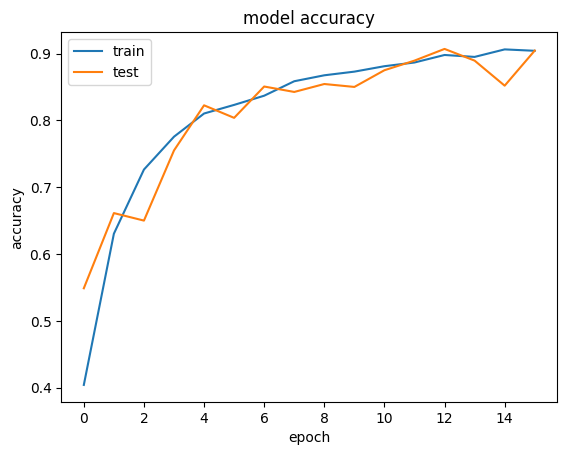

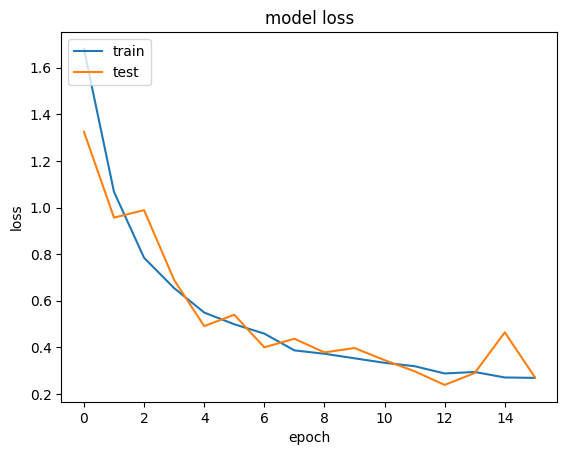

In [29]:
plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Actual label : Late_blight
1/1 [==============================] - 0s 24ms/step
Label predict : Early_blight


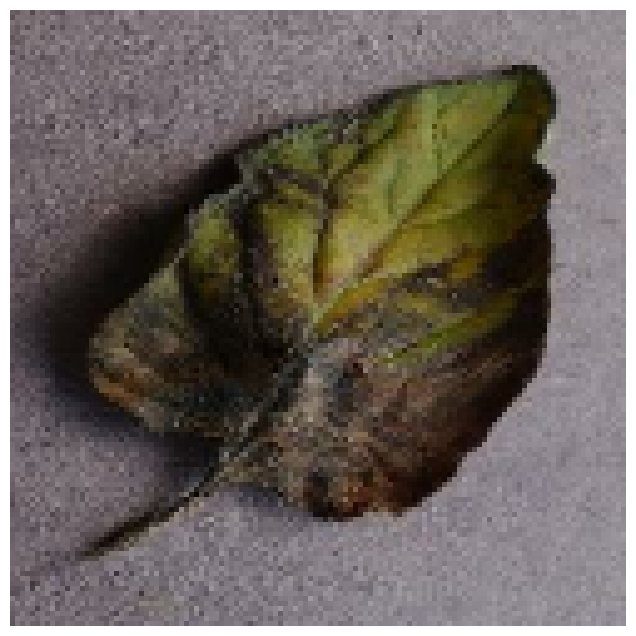

Actual label : YellowLeaf__Curl_Virus
1/1 [==============================] - 0s 25ms/step
Label predict : YellowLeaf__Curl_Virus


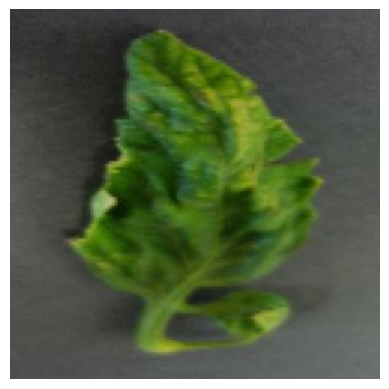

Actual label : YellowLeaf__Curl_Virus
1/1 [==============================] - 0s 26ms/step
Label predict : YellowLeaf__Curl_Virus


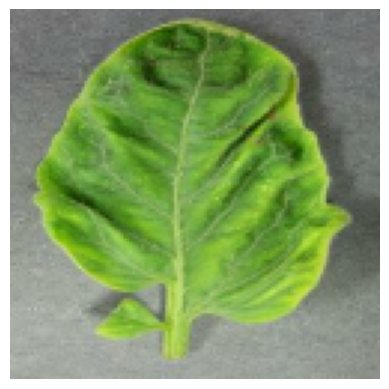

Actual label : Leaf_Mold
1/1 [==============================] - 0s 20ms/step
Label predict : Leaf_Mold


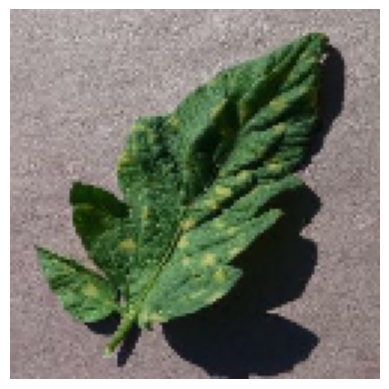

Actual label : healthy
1/1 [==============================] - 0s 26ms/step
Label predict : healthy


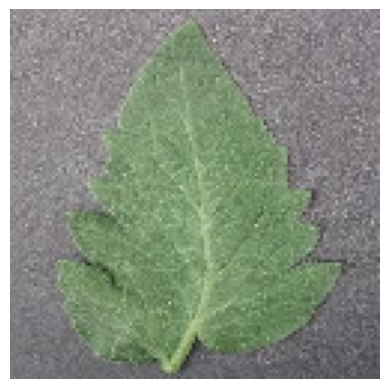

Actual label : Spider_mites_Two_spotted_spider_mite
1/1 [==============================] - 0s 22ms/step
Label predict : Spider_mites_Two_spotted_spider_mite


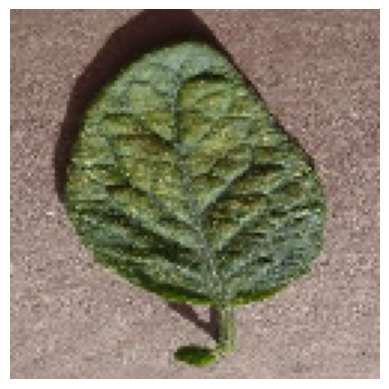

In [34]:
plt.figure(figsize=(8, 8))
for image_batchs, label in test_ds.take(1):
  for idx in range(6):
    first_image = image_batchs[idx].numpy().astype('uint8')
    first_label = label[idx].numpy()
    plt.imshow(first_image)
    print(f'Actual label : {class_names[first_label]}')
    batch_predict = model.predict(image_batchs)
    print(f'Label predict : {class_names[np.argmax(batch_predict[idx])]}')
    plt.axis("off")
    plt.show()

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


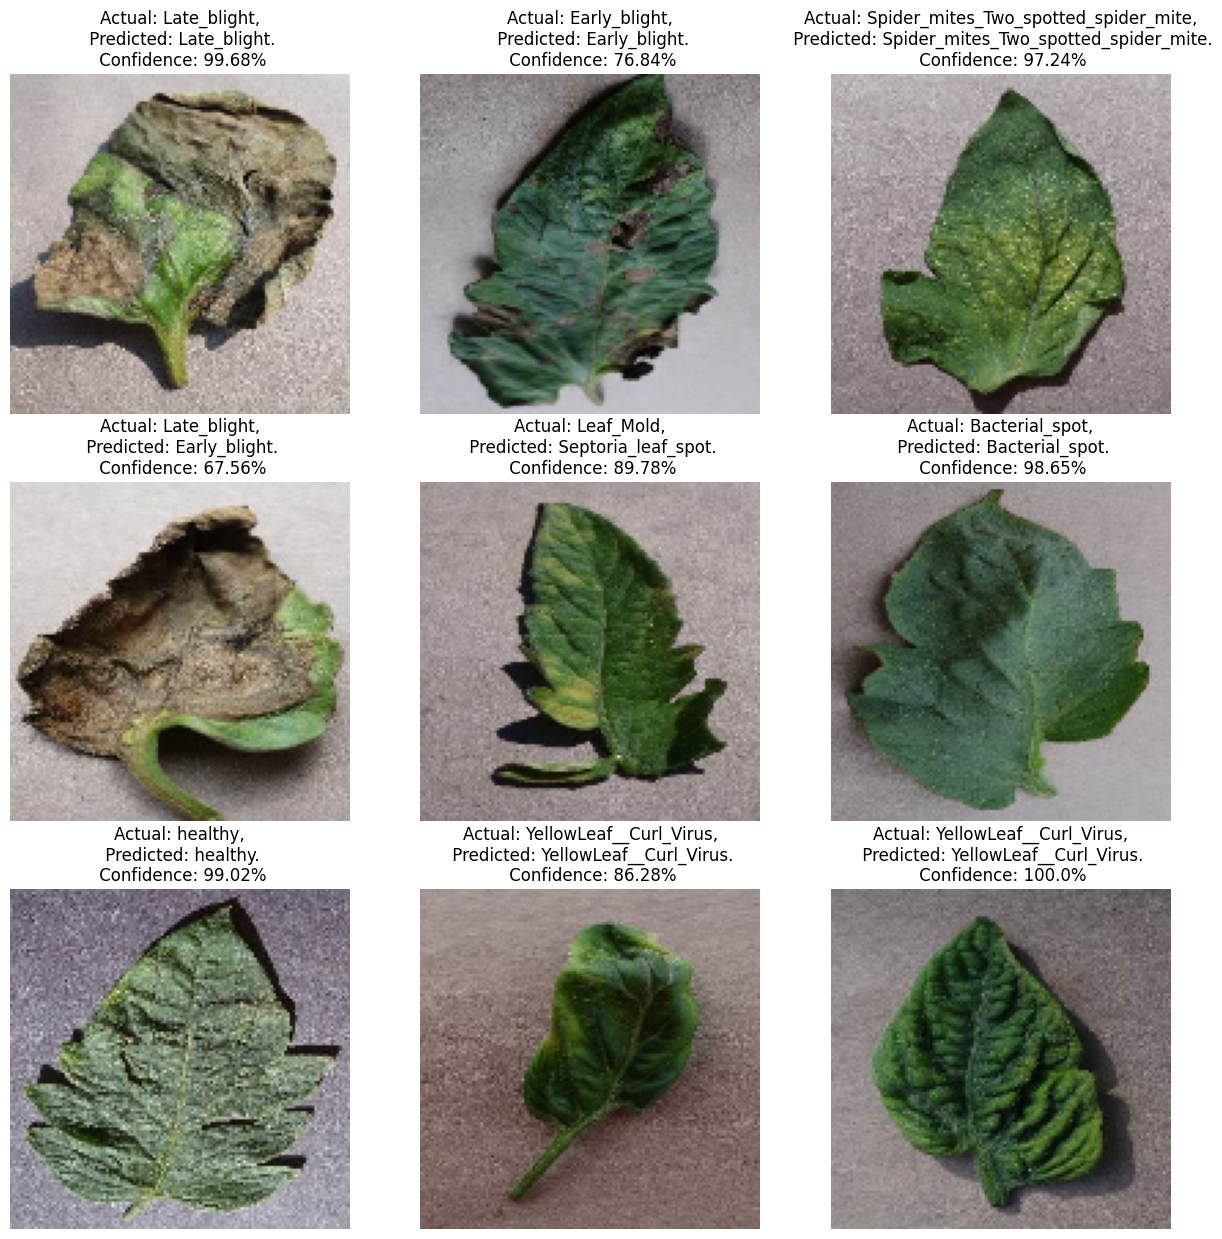

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
    break

In [22]:
model.save('saved_model/tomato_diseases')

In [20]:
model.save('tomato_diseases.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
!zip -r tomato_diseases.zip saved_model/tomato_diseases

  adding: saved_model/tomato_diseases/ (stored 0%)
  adding: saved_model/tomato_diseases/fingerprint.pb (stored 0%)
  adding: saved_model/tomato_diseases/variables/ (stored 0%)
  adding: saved_model/tomato_diseases/variables/variables.data-00000-of-00001 (deflated 16%)
  adding: saved_model/tomato_diseases/variables/variables.index (deflated 67%)
  adding: saved_model/tomato_diseases/assets/ (stored 0%)
  adding: saved_model/tomato_diseases/saved_model.pb (deflated 88%)
  adding: saved_model/tomato_diseases/keras_metadata.pb (deflated 93%)


In [27]:
from google.colab import files

# If you created a zip file
files.download('tomato_diseases.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Conclusion**:
In the scope of this project, we have developed an image classification model for tomato leaf diseases with a validation accuracy of 90%. This achievement demonstrates the capacity of computer vision and machine learning to accurately identify tomato leaf diseases. Our model can contribute to crop health monitoring and early disease detection, providing a valuable tool for farmers.

### **Future Perspectives**:
The application of our model in agriculture offers numerous future prospects:
- **Integration into Automated Monitoring Systems**: Our model can be integrated into automated crop monitoring systems, enabling farmers to track their plant's health in real-time.
- **Optimization of Pesticide Usage**: Precise utilization of our model can contribute to optimizing pesticide usage, reducing costs and environmental impacts.
- **Development of User-Friendly Tools for Farmers**: Creating training and awareness tools based on our model can help educate and sensitize farmers about tomato leaf disease management.
- **Collaboration with Agriculture Experts**: Collaboration with agriculture experts can help customize and tailor our model to the specific needs of agriculture.
- **Improving Tomato Crop Sustainability**: Overall, our model has the potential to enhance the sustainability and productivity of tomato crops, which is crucial in addressing global food challenges.

In conclusion, our tomato leaf disease image classification model paves the way for more efficient, sustainable, and resilient agriculture. By combining cutting-edge technology with agriculture expertise, we can significantly contribute to food security and crop health.